In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import seaborn as sb




In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the dataset
data = pd.read_csv('/content/data.csv')

data.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


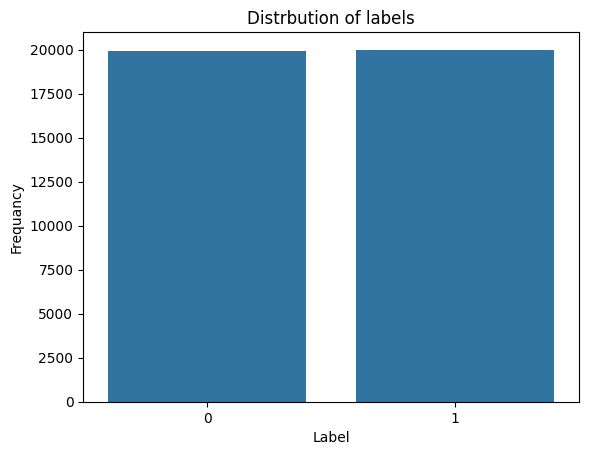

In [ ]:
sb.countplot(x='label',data=data)
plt.title("Distrbution of labels")
plt.xlabel("Label")
plt.ylabel("Frequancy")
plt.show();

In [ ]:
# Preprocessing function
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [ ]:
data['text'] = data['text'].apply(preprocess_text)

In [ ]:

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=0.02)


In [ ]:

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# rain the model using Multinomial Naive Bayes
classifier = MultinomialNB(alpha=0.5)

# Train the classifier on the transformed training data
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 92.28%


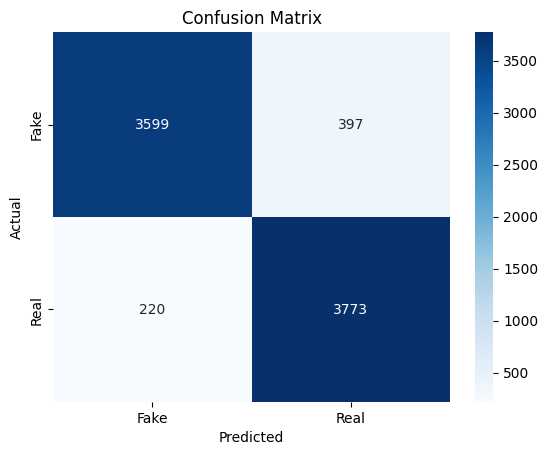

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Create a pipeline with TF-IDF vectorizer and Multinomial Naive Bayes classifier
pipeline = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier)])

# Save the entire pipeline
joblib.dump(pipeline, 'text_classification_pipeline.pkl')


['text_classification_pipeline.pkl']

In [ ]:
loaded_pipeline = joblib.load('text_classification_pipeline.pkl')

# Use the loaded pipeline to make predictions on the test set
y_pred_loaded = loaded_pipeline.predict(X_test)

# Evaluate the accuracy of the loaded model
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print(f'Loaded model accuracy: {accuracy_loaded * 100:.2f}%')

Loaded model accuracy: 92.28%


#CNN


In [ ]:
# Tokenizer
MAX_WORDS = 20000
MAX_SEQ_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH)

print(f"Padded sequences shape: {X_train_pad.shape}")


Padded sequences shape: (31953, 300)


In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim=300):
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings

# Load GloVe file
glove_file = 'glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

# Create embedding matrix
EMBEDDING_DIM = 300
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, idx in tokenizer.word_index.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")


Embedding matrix shape: (187719, 300)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CNN Model
model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False),

    Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer='l2'),  # L2 Regularization
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # Dropout to reduce overfitting

    Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer='l2'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # Dropout again

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),  # Another dropout layer
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add Early Stopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=10,  # Increased epochs, but early stopping will prevent overtraining
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy (CNN + GloVe): {accuracy:.2f}")


Epoch 1/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 268s 266ms/step - accuracy: 0.7590 - loss: 1.4465 - val_accuracy: 0.9781 - val_loss: 0.2522 - learning_rate: 0.0010
Epoch 2/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 259s 259ms/step - accuracy: 0.9702 - loss: 0.2714 - val_accuracy: 0.9817 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 3/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 240s 237ms/step - accuracy: 0.9739 - loss: 0.2431 - val_accuracy: 0.9810 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 4/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 243s 244ms/step - accuracy: 0.9744 - loss: 0.2289 - val_accuracy: 0.9864 - val_loss: 0.1924 - learning_rate: 0.0010
Epoch 5/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 260s 242ms/step - accuracy: 0.9744 - loss: 0.2262 - val_accuracy: 0.9756 - val_loss: 0.2281 - learning_rate: 0.0010
Epoch 6/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 262s 262ms/step - accuracy: 0.9763 - loss: 0.2167 - val_accuracy: 0.9860 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 7/10
999/999 ━━━━━━━━━━━━━━━━━━━━ 245s 245ms/step - accura

In [ ]:

test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9896 - loss: 0.1158
Test Accuracy: 0.99
Test Loss: 0.12


In [ ]:
# Save model in the native Keras format
model.save('fake_news_cnn_model.keras')


In [ ]:
# Load the model without loading the optimizer state
loaded_model = load_model('fake_news_cnn_model.keras', compile=False)

# Now compile the model manually
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


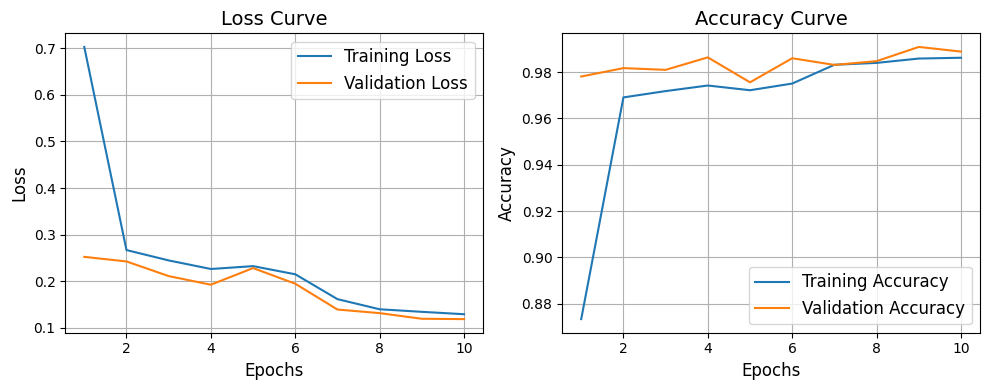

In [ ]:
import matplotlib.pylab as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Create a figure with specific size
plt.figure(figsize=(10, 4))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curve', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)  # Add gridlines for better readability

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step


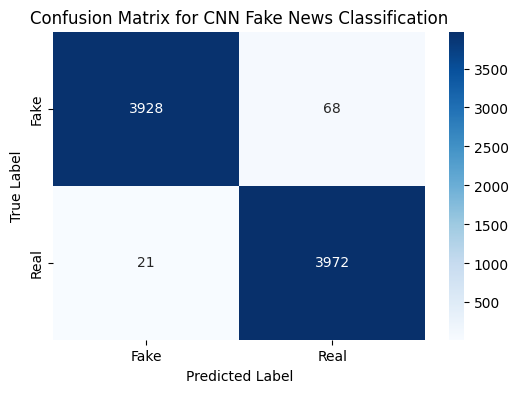

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for CNN Fake News Classification")
plt.show()
